In [21]:
import os
import sys
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from pathlib import Path

# Agregar la carpeta raíz al path para poder importar scripts si fuera necesario
# (aunque usaremos ejecución directa por consola para aislar procesos)
project_root = Path("..").resolve()
sys.path.append(str(project_root))

print(f"Directorio raíz del proyecto: {project_root}")

Directorio raíz del proyecto: D:\laboratorio_cambio_urbano


In [24]:
# 1. Descargar Vectores (Límites, Censo, Vías)
# El script ya tiene lógica interna para no descargar si ya existe, así que es seguro correrlo.
print("--- Verificando Vectores ---")
!python ../scripts/download_vectors.py --sources all

# 2. Descargar Imágenes Satelitales (Sentinel-2)
print("\n--- Verificando Imágenes Sentinel-2 ---")
!python ../scripts/download_sentinel.py

--- Verificando Vectores ---
🚀 Ejecutando descarga de vectores. Modo: ALL
📍 Directorio: D:\laboratorio_cambio_urbano\data\vector

✅ [IDE] Límite comunal ya existe. Saltando...
✅ [INE] Manzanas censales ya existen. Saltando...
✅ [OSM] Red vial ya existe. Saltando...

🏁 Proceso finalizado.

--- Verificando Imágenes Sentinel-2 ---
📍 Los datos se guardarán en: D:\laboratorio_cambio_urbano\data\raw
🔌 Conectando a GEE con proyecto: composed-augury-451119-b6...
✅ GEE inicializado.
🚀 Iniciando descarga (Filtro Relajado 30% Nubes)...

✅ [YA EXISTE] sentinel2_2019.tif
✅ [YA EXISTE] sentinel2_2020.tif
✅ [YA EXISTE] sentinel2_2021.tif
✅ [YA EXISTE] sentinel2_2022.tif
✅ [YA EXISTE] sentinel2_2023.tif
✅ [YA EXISTE] sentinel2_2024.tif
✅ [YA EXISTE] sentinel2_2025.tif

🏁 Listo.


⏳ Cargando vectores...


C:\Users\Carloto\AppData\Roaming\Python\Python312\site-packages\geopandas\io\file.py:576: UserWarning: Could not parse column 'reversed' as JSON; leaving as string
  return pyogrio.read_dataframe(path_or_bytes, bbox=bbox, **kwargs)


⚠️ Red Vial estaba en EPSG:4326. Reproyectando...
✅ Todos los vectores alineados en EPSG:32719.
🗺️ Generando mapa final...


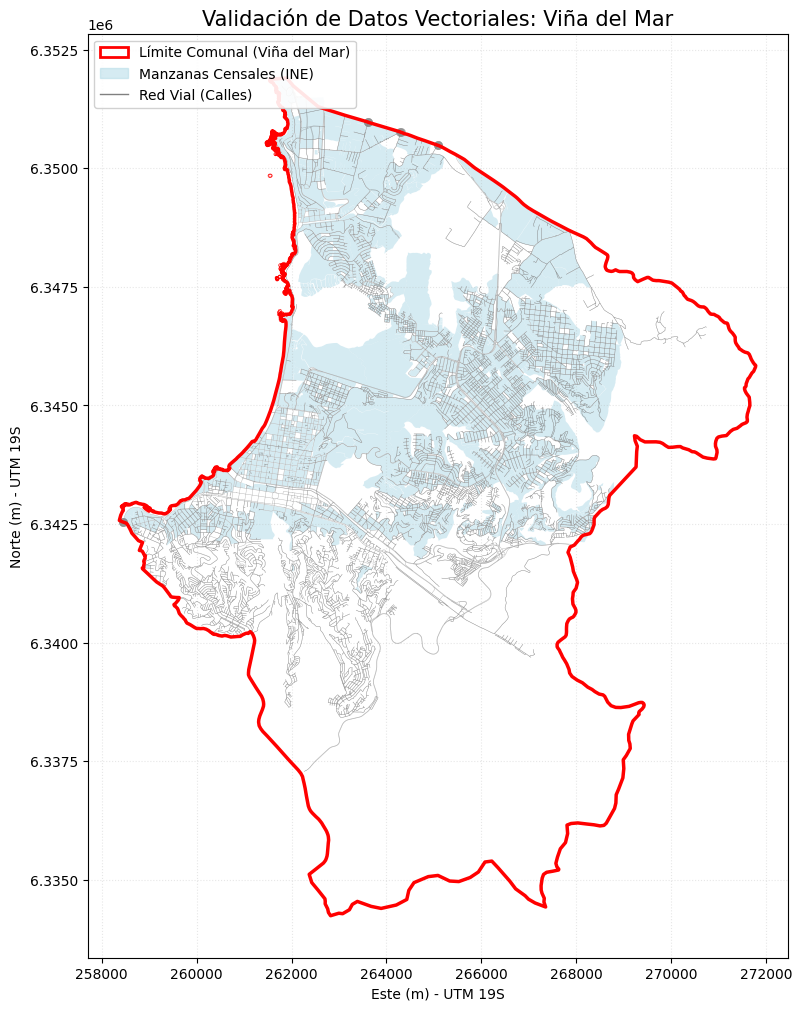

In [17]:
# Celda 3: Validación Visual de Vectores (FINAL PARA INFORME)
# ======================================================
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Definir rutas
vector_dir = project_root / "data" / "vector"
limite_path = vector_dir / "limite_comuna.gpkg"
manzanas_path = vector_dir / "manzanas_censales.shp"
vias_path = vector_dir / "red_vial.geojson"

try:
    # 1. Cargar datos
    print("⏳ Cargando vectores...")
    gdf_limite = gpd.read_file(limite_path)
    gdf_manzanas = gpd.read_file(manzanas_path)
    gdf_vias = gpd.read_file(vias_path)

    # 2. REPARACIÓN DE COORDENADAS (CRUCIAL)
    target_crs = "EPSG:32719"
    
    if gdf_limite.crs.to_string() != target_crs:
        gdf_limite = gdf_limite.to_crs(target_crs)
        
    if gdf_manzanas.crs.to_string() != target_crs:
        gdf_manzanas = gdf_manzanas.to_crs(target_crs)
        
    if gdf_vias.crs.to_string() != target_crs:
        print(f"⚠️ Red Vial estaba en {gdf_vias.crs}. Reproyectando...")
        gdf_vias = gdf_vias.to_crs(target_crs)

    print("✅ Todos los vectores alineados en EPSG:32719.")

    # 3. Recortar vías (Para limpieza visual)
    try:
        gdf_vias = gpd.clip(gdf_vias, gdf_limite)
    except:
        pass 

    # 4. Visualización
    fig, ax = plt.subplots(figsize=(12, 12)) 
    
    # --- CAPAS ---
    # A. Manzanas (Fondo)
    gdf_manzanas.plot(ax=ax, color='lightblue', alpha=0.5, zorder=1)
    
    # B. Vías (Medio)
    gdf_vias.plot(ax=ax, color='gray', linewidth=0.3, alpha=0.6, zorder=2)
    
    # C. Límite (Arriba)
    gdf_limite.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2.5, zorder=3)

    # --- LEYENDA PERSONALIZADA ---
    # Creamos "elementos falsos" para explicar el mapa claramente
    leyenda_elementos = [
        mpatches.Patch(facecolor='none', edgecolor='red', linewidth=2, label='Límite Comunal (Viña del Mar)'),
        mpatches.Patch(color='lightblue', alpha=0.5, label='Manzanas Censales (INE)'),
        mlines.Line2D([], [], color='gray', linewidth=1, label='Red Vial (Calles)')
    ]
    
    ax.legend(handles=leyenda_elementos, loc='upper left', fontsize=10, frameon=True, framealpha=0.9)

    # Ajustes del mapa
    ax.set_aspect('equal') 
    plt.title("Validación de Datos Vectoriales: Viña del Mar", fontsize=15)
    plt.xlabel("Este (m) - UTM 19S")
    plt.ylabel("Norte (m) - UTM 19S")
    plt.grid(True, linestyle=':', alpha=0.3)
    
    print("🗺️ Generando mapa final...")
    plt.show()

except Exception as e:
    print(f"❌ Error visualizando: {e}")

📂 Encontradas 7 imágenes. Generando panel de control...


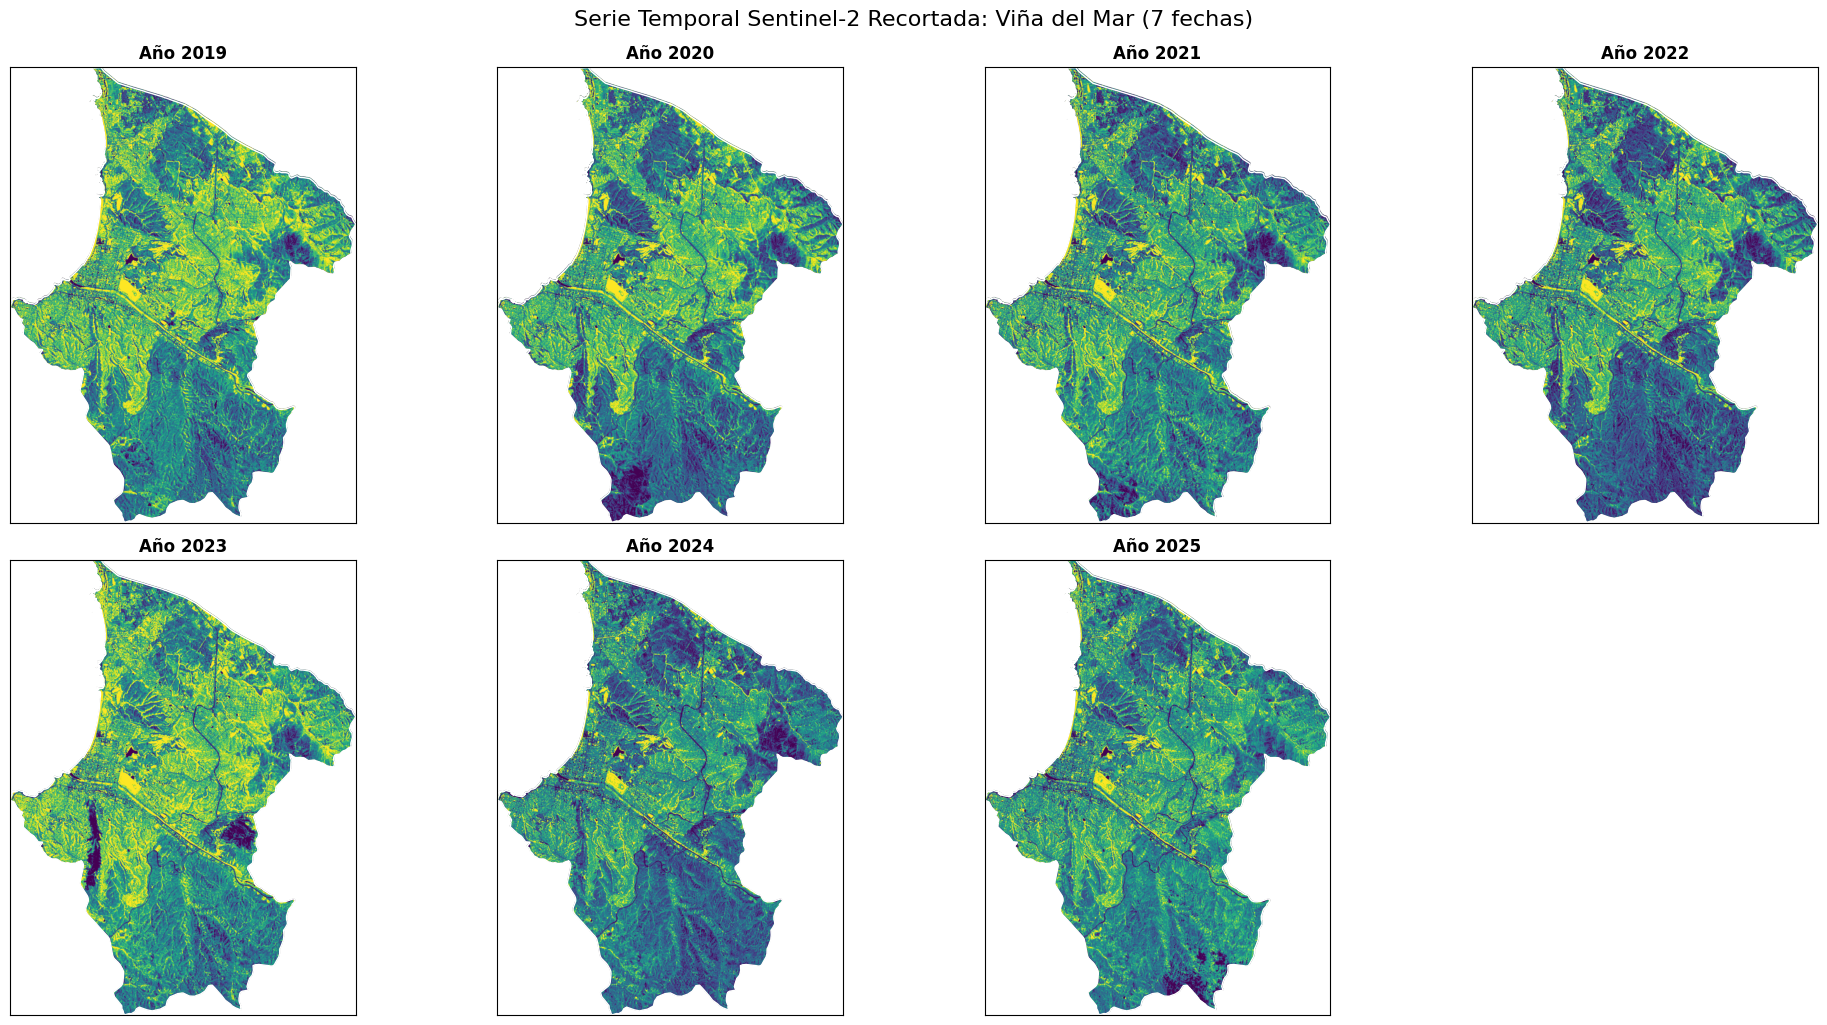

In [26]:
# Celda 4: Visualización de Serie Temporal Recortada (Masking)
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask # <--- Herramienta clave para recortar

# Configuración
raw_dir = project_root / "data" / "raw"
imagenes = sorted(list(raw_dir.glob("sentinel2_*.tif")))
vector_path = project_root / "data" / "vector" / "limite_comuna.gpkg"
gdf_limite = gpd.read_file(vector_path)

if not imagenes:
    print("❌ No hay imágenes.")
else:
    print(f"📂 Encontradas {len(imagenes)} imágenes. Generando panel de control...")

    # Configurar el gráfico (Grid de 2 filas x 4 columnas para 7 imágenes)
    cols = 4
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten() # Aplanar para iterar fácil

    # Iterar sobre cada imagen
    for idx, img_path in enumerate(imagenes):
        ax = axes[idx]
        year = img_path.stem.split("_")[1]
        
        with rasterio.open(img_path) as src:
            # 1. Asegurar que el vector esté en la misma proyección que la imagen
            if gdf_limite.crs != src.crs:
                gdf_limite = gdf_limite.to_crs(src.crs)
            
            # 2. EL RECORTE MÁGICO (Masking)
            # Usamos la geometría del vector para recortar el raster
            shapes = [geom for geom in gdf_limite.geometry]
            out_image, out_transform = mask(src, shapes, crop=True)
            
            # out_image tiene forma (Bandas, Alto, Ancho). 
            # La banda NIR es la 4ta (índice 3 en Python 0-based index)
            # PERO rasterio.mask devuelve todas las bandas leídas.
            # Si leímos todo, índice 3 es la banda 4 (B8).
            nir = out_image[3].astype(float) # Banda 4 (NIR)
            
            # 3. Limpieza de datos (igual que antes)
            nir[nir <= 0] = np.nan
            nir[np.isinf(nir)] = np.nan
            
            # 4. Visualización
            if np.nanmax(nir) > 0:
                # Contraste automático
                vmin, vmax = np.nanpercentile(nir, [2, 98])
                
                # Mostrar imagen recortada
                # Usamos extent para que las coordenadas sean correctas tras el recorte
                show(nir, transform=out_transform, ax=ax, cmap='viridis', 
                     vmin=vmin, vmax=vmax)
                
                ax.set_title(f"Año {year}", fontsize=12, fontweight='bold')
                
                # Opcional: Poner el borde encima para resaltar
                gdf_limite.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
            else:
                ax.set_title(f"{year} (VACÍA)", color='red')
            
            # Quitar ejes numéricos para limpieza visual
            ax.set_xticks([])
            ax.set_yticks([])

    # Apagar los subplots que sobren (si hay huecos en la grilla)
    for i in range(len(imagenes), rows * cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.suptitle(f"Serie Temporal Sentinel-2 Recortada: Viña del Mar ({len(imagenes)} fechas)", fontsize=16, y=1.02)
    plt.show()
